In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import BooleanArrayMask
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView
from astropy.time import Time
import pandas as pd

Vizier.ROW_LIMIT = -1

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline

<SkyCoord (ICRS): (ra, dec) in deg
    (202.77287917, -22.60543056)>
(432, 1, 4609, 4608)
number of sources: 25


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


4 sigma detections: 23


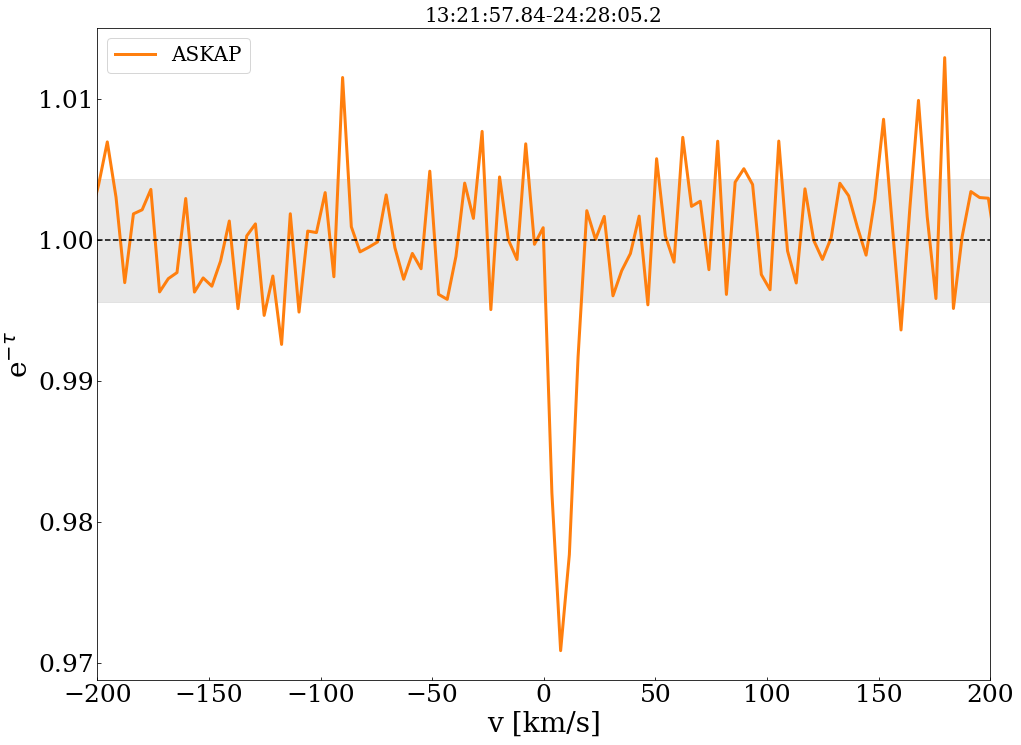

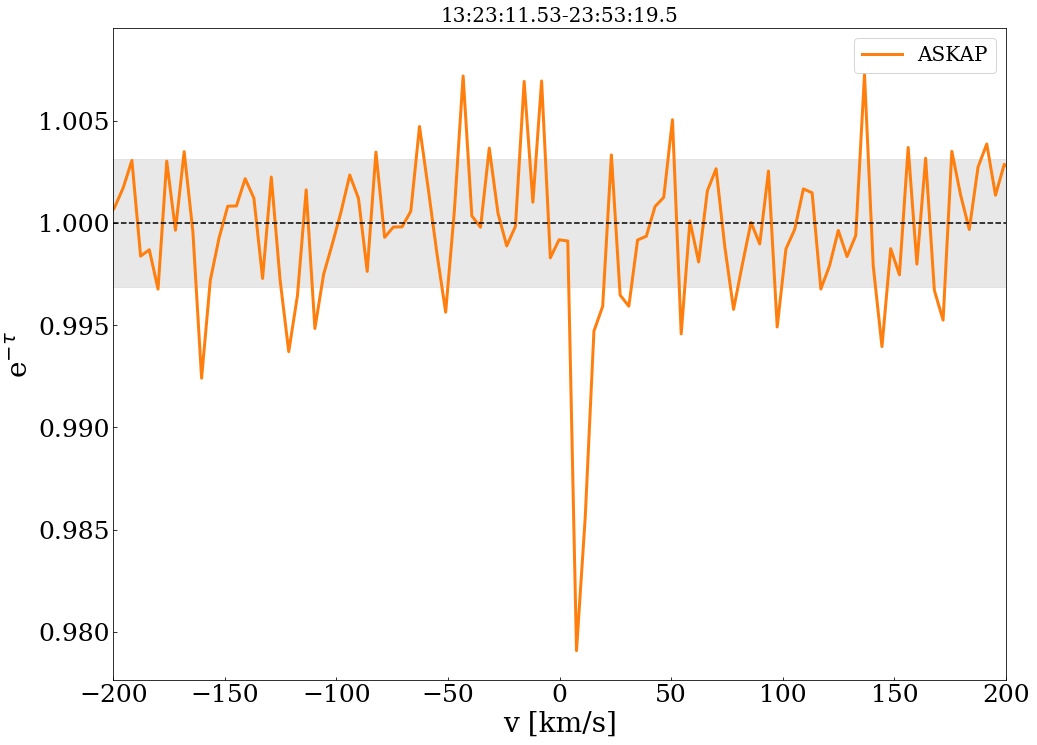

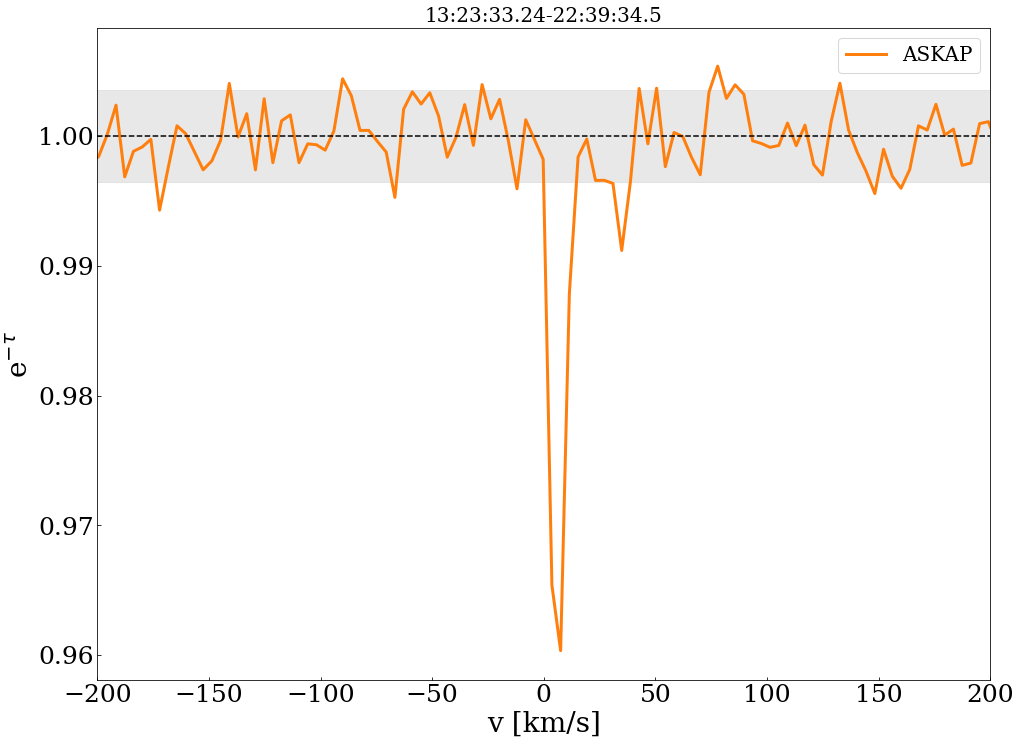

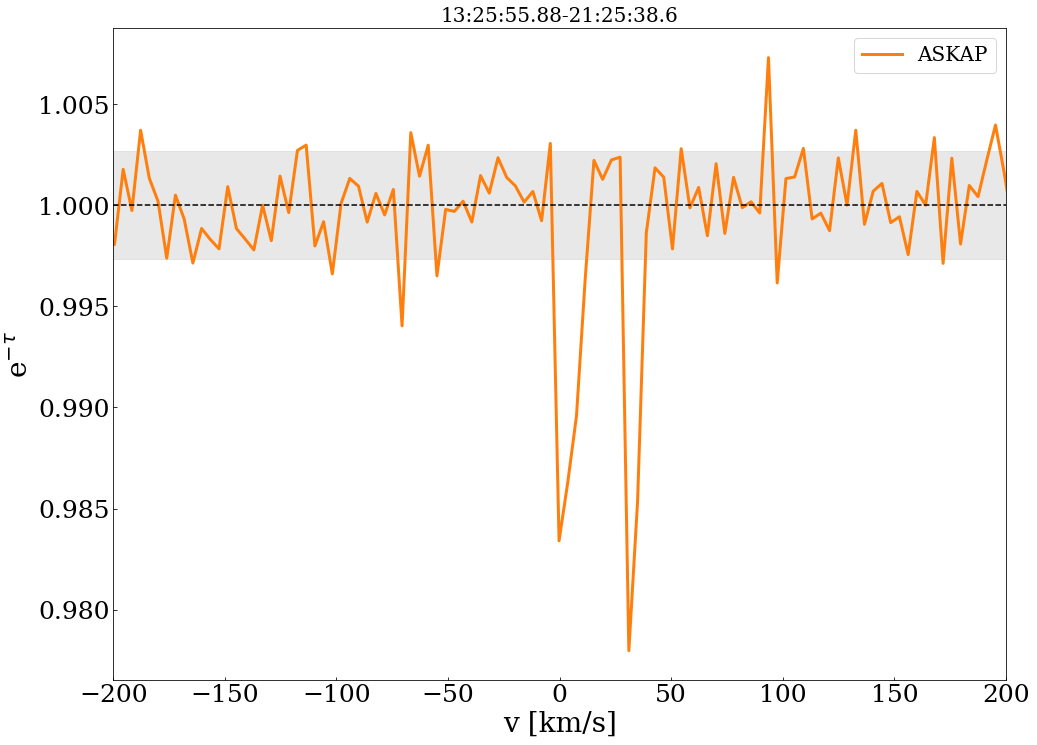

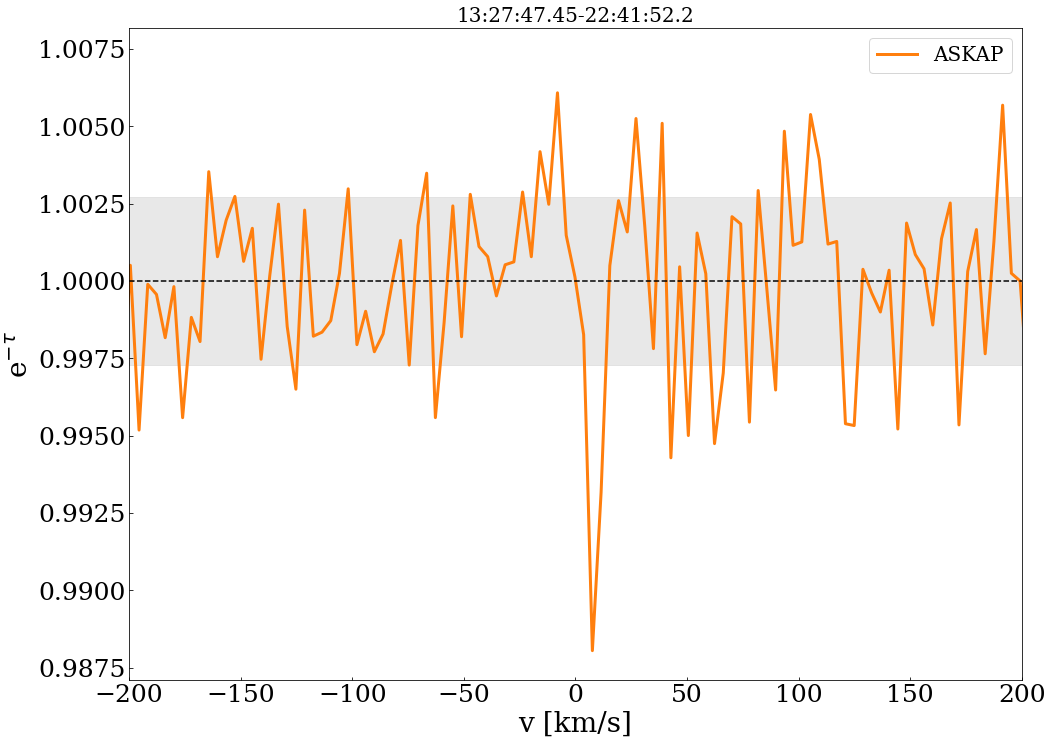

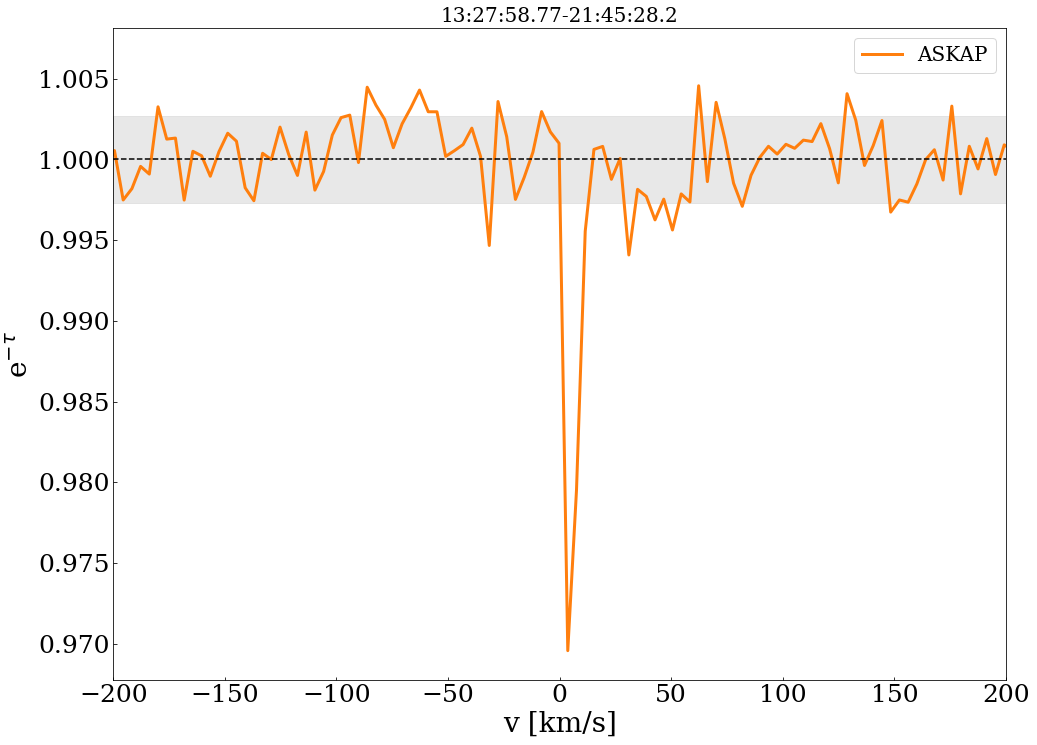

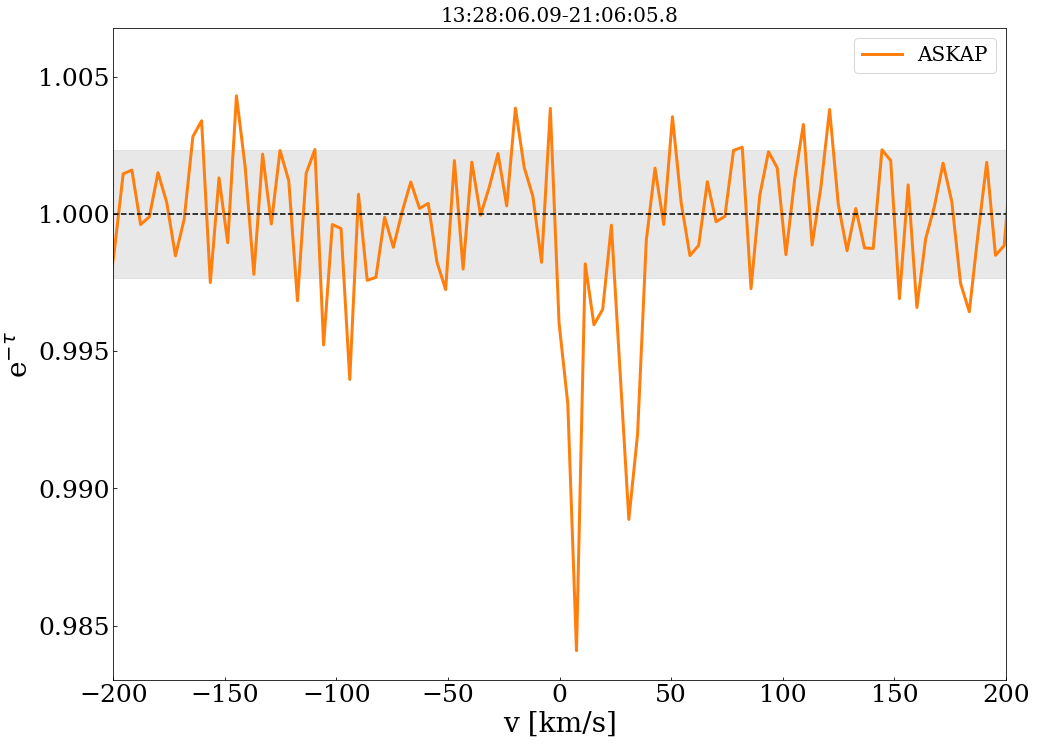

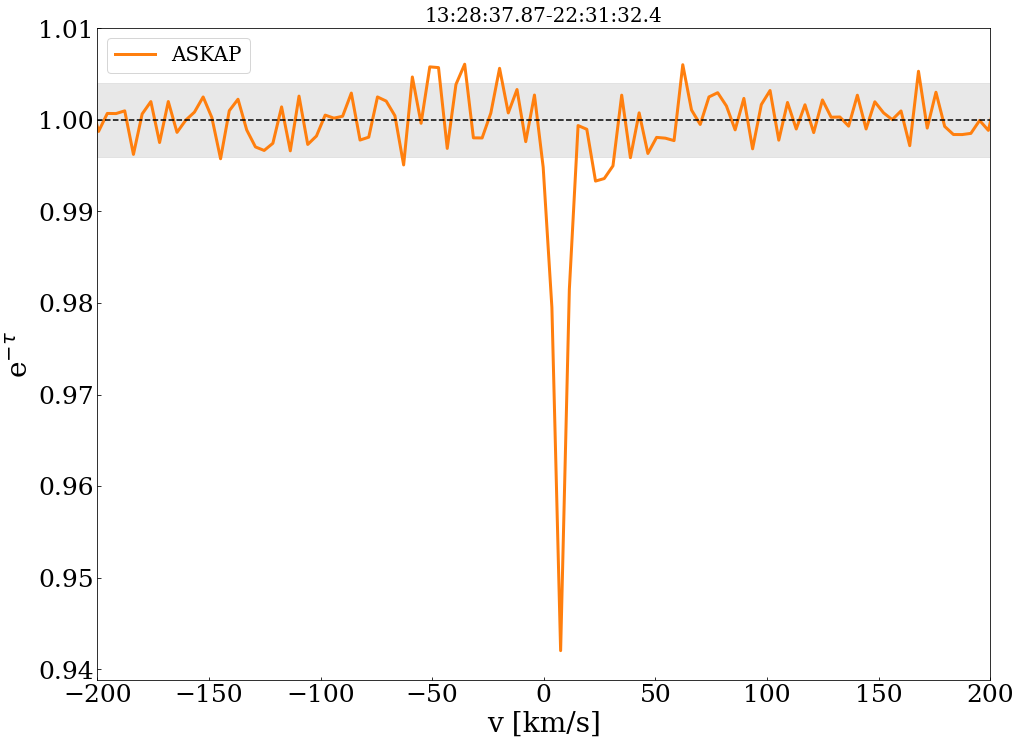

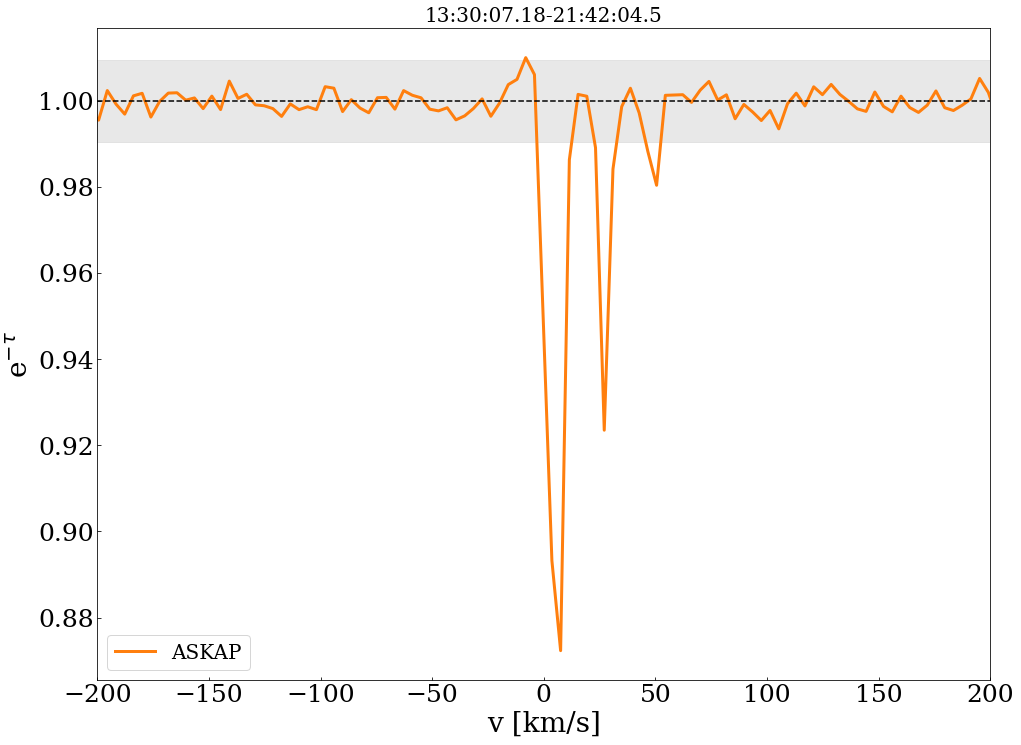

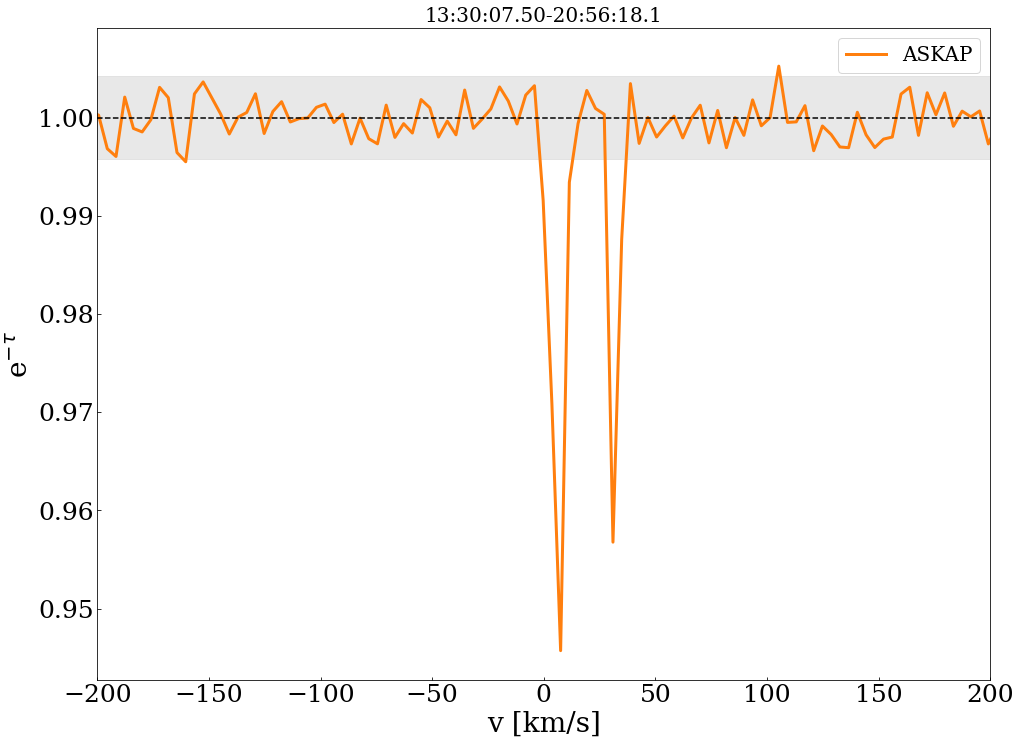

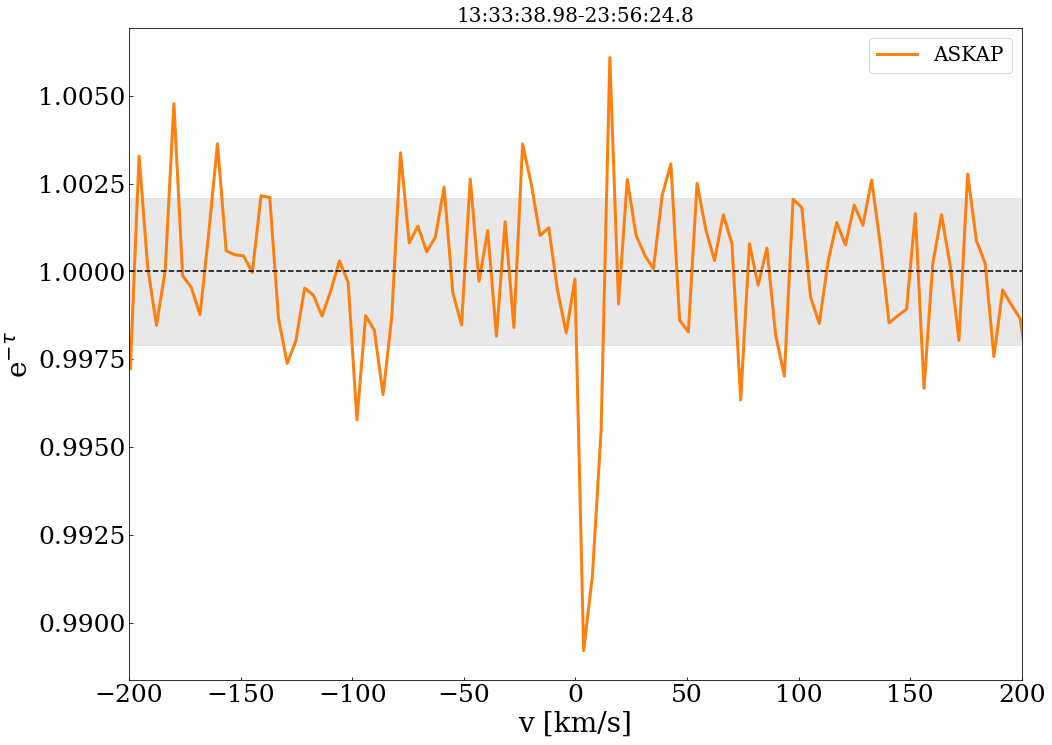

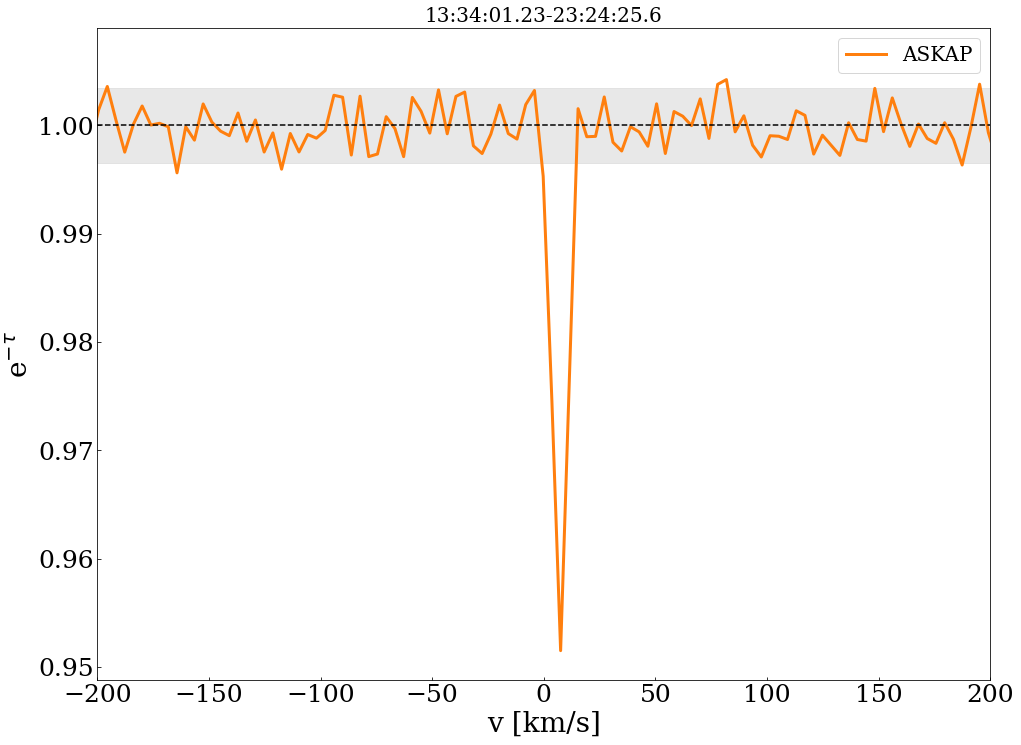

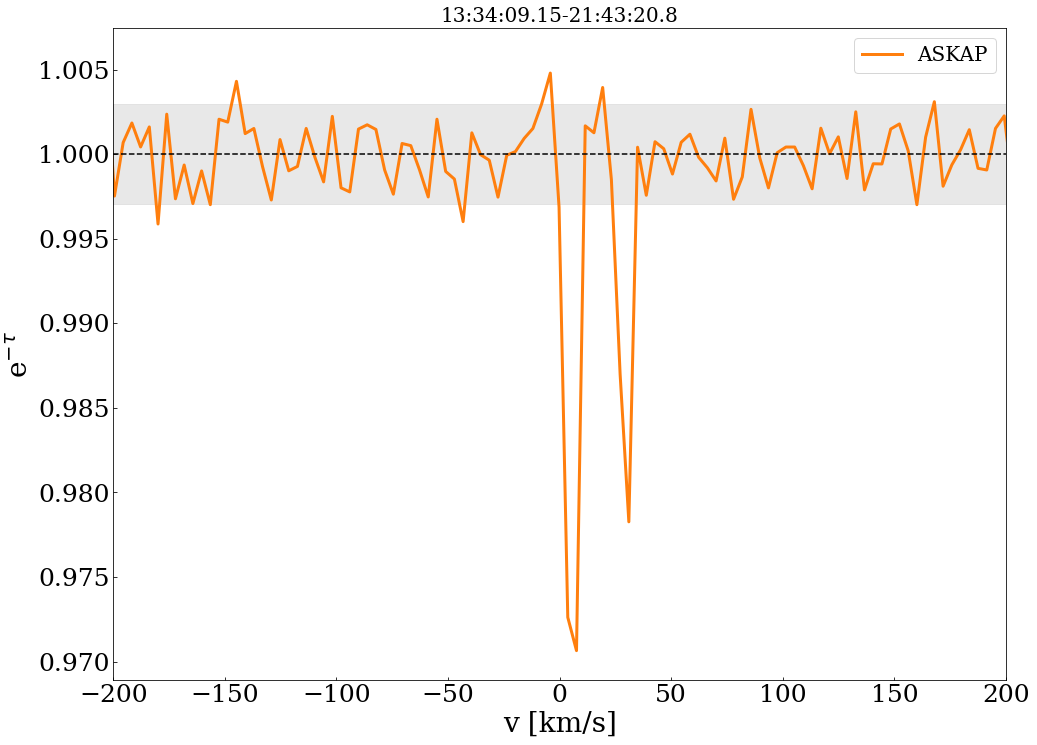

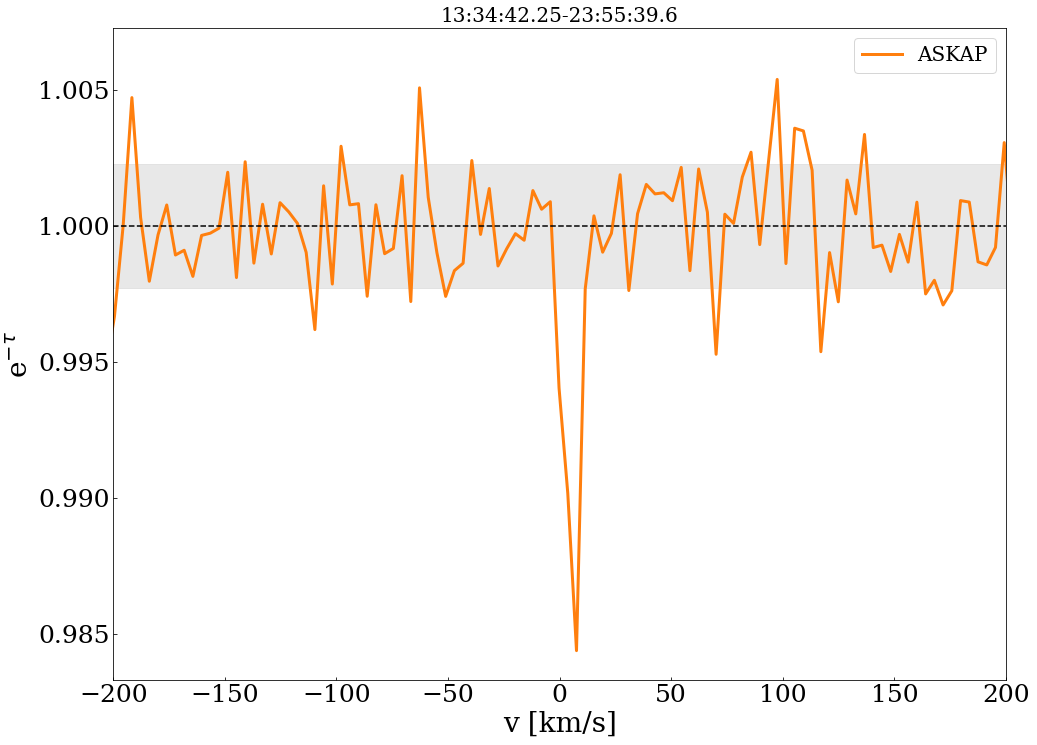

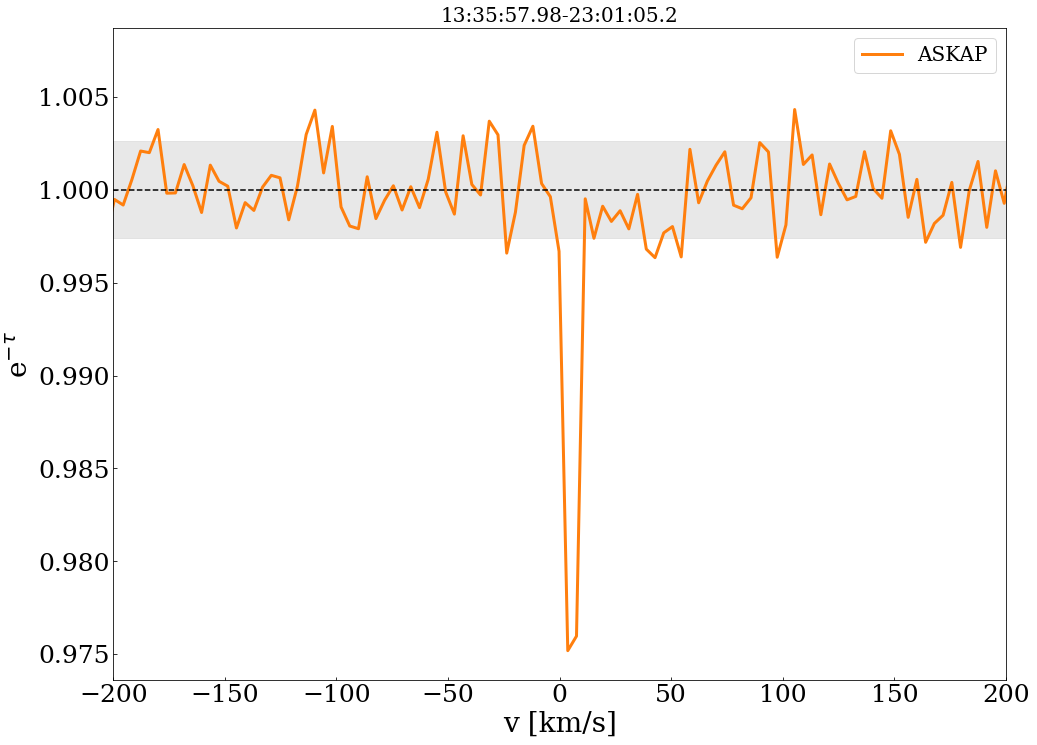

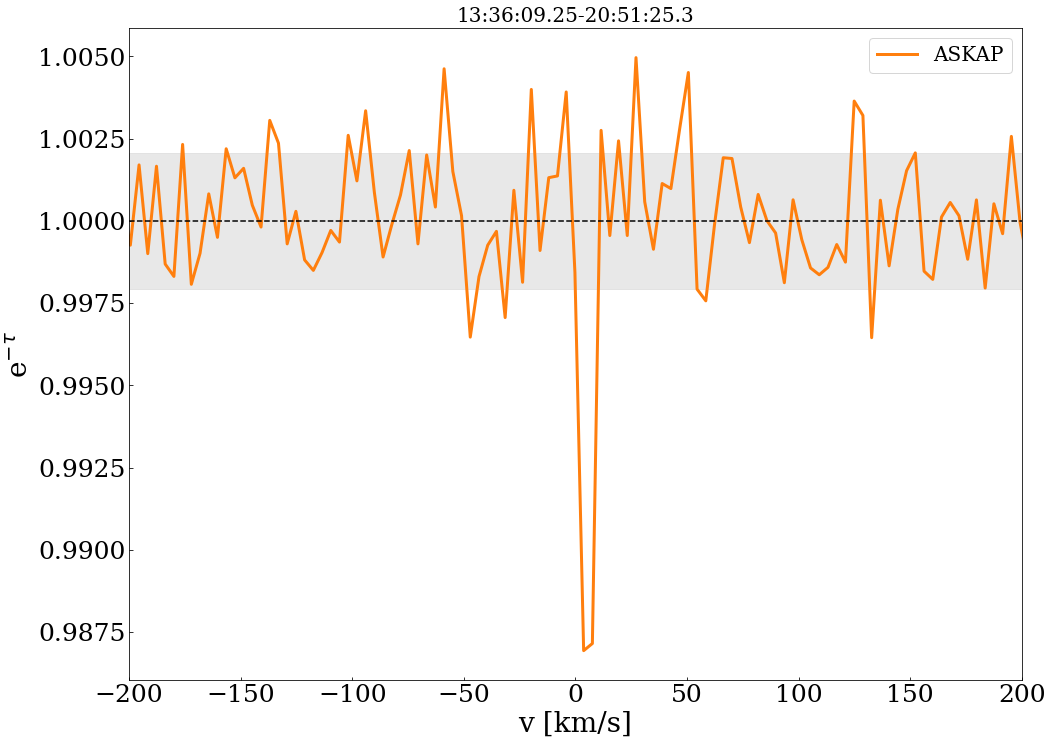

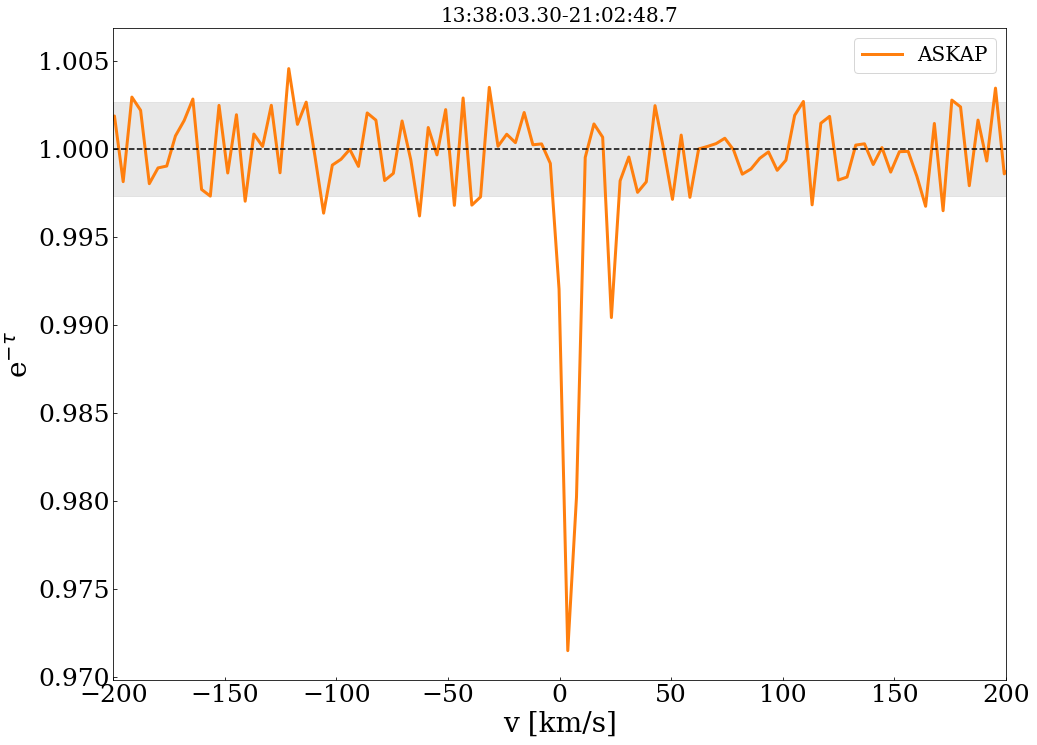

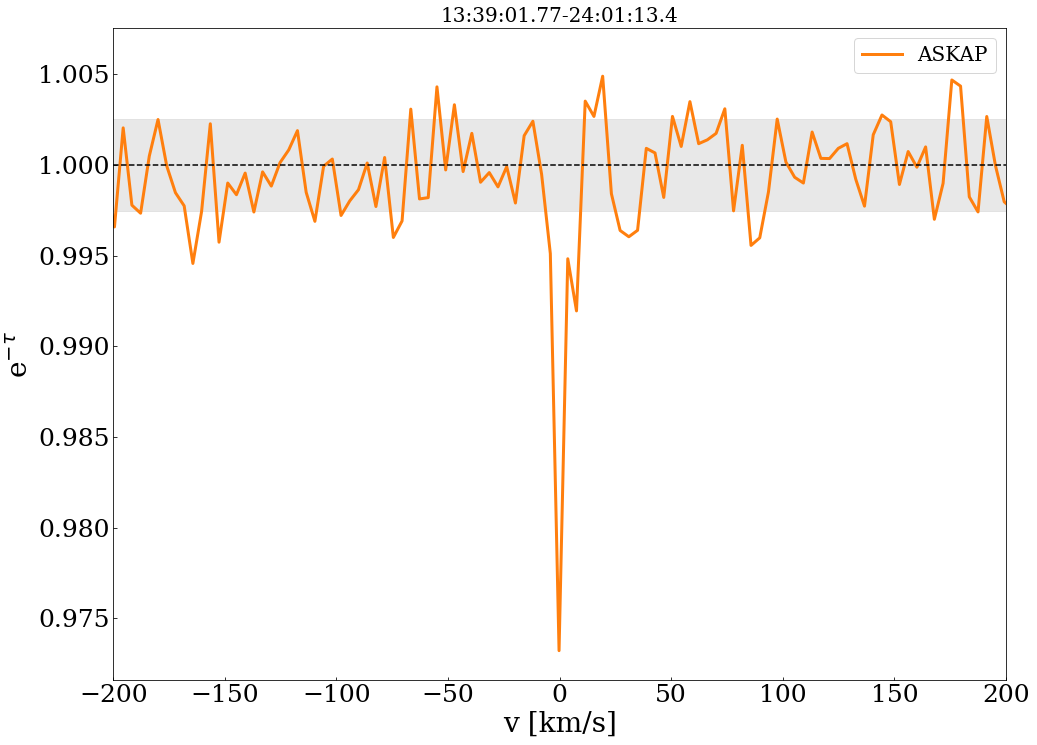

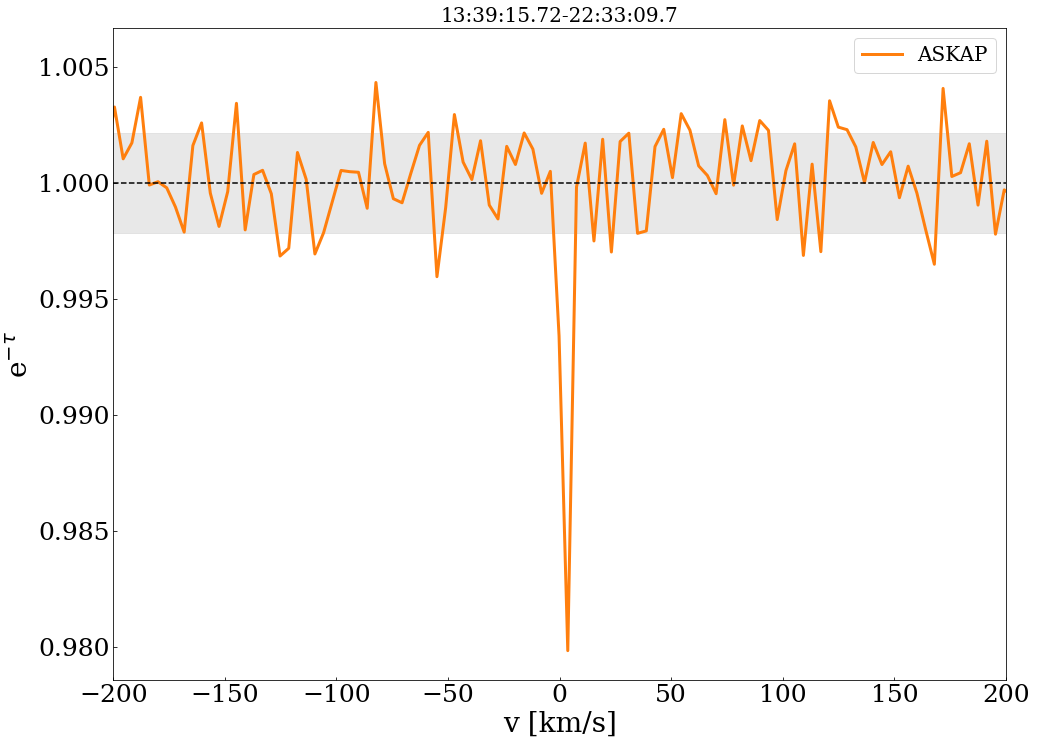

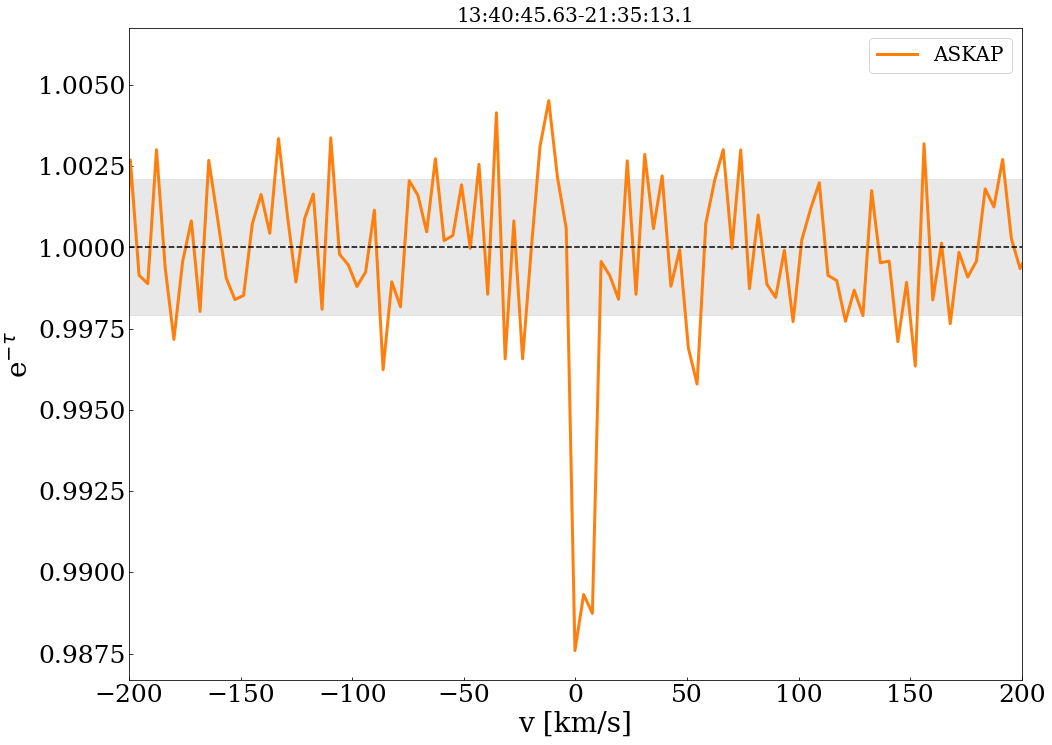

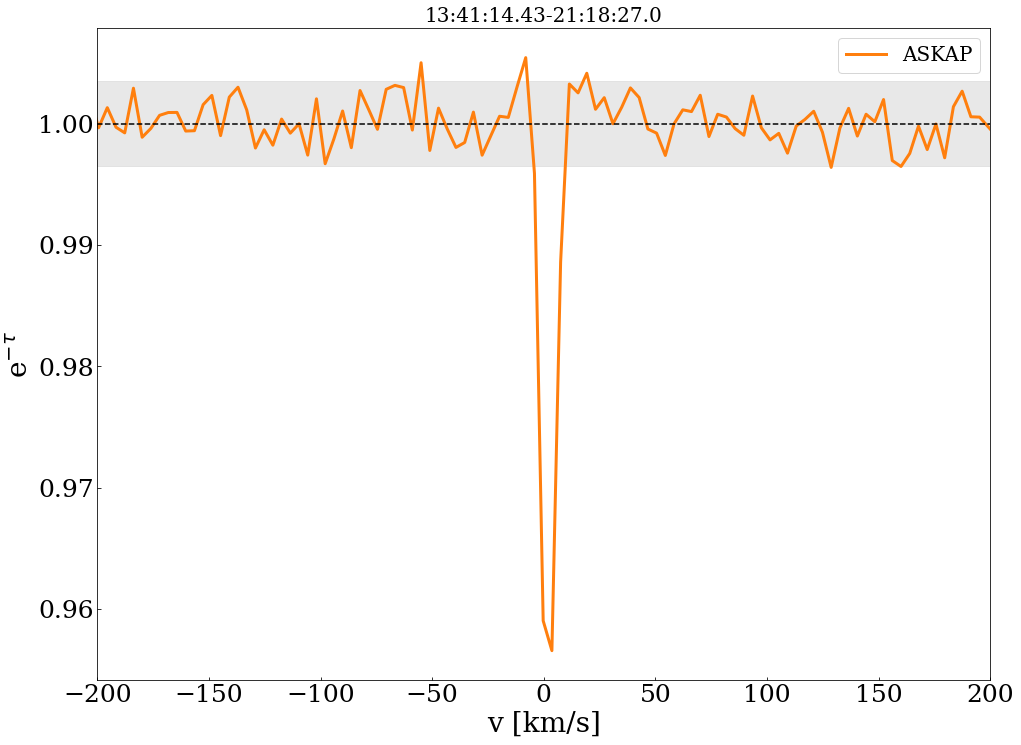

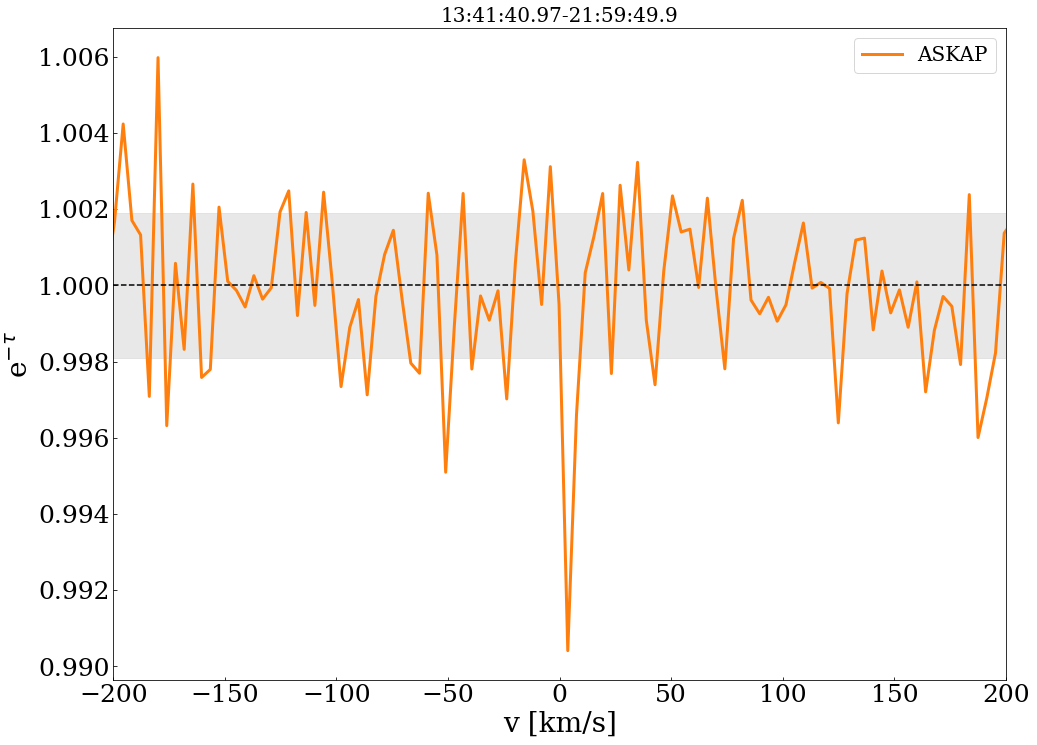

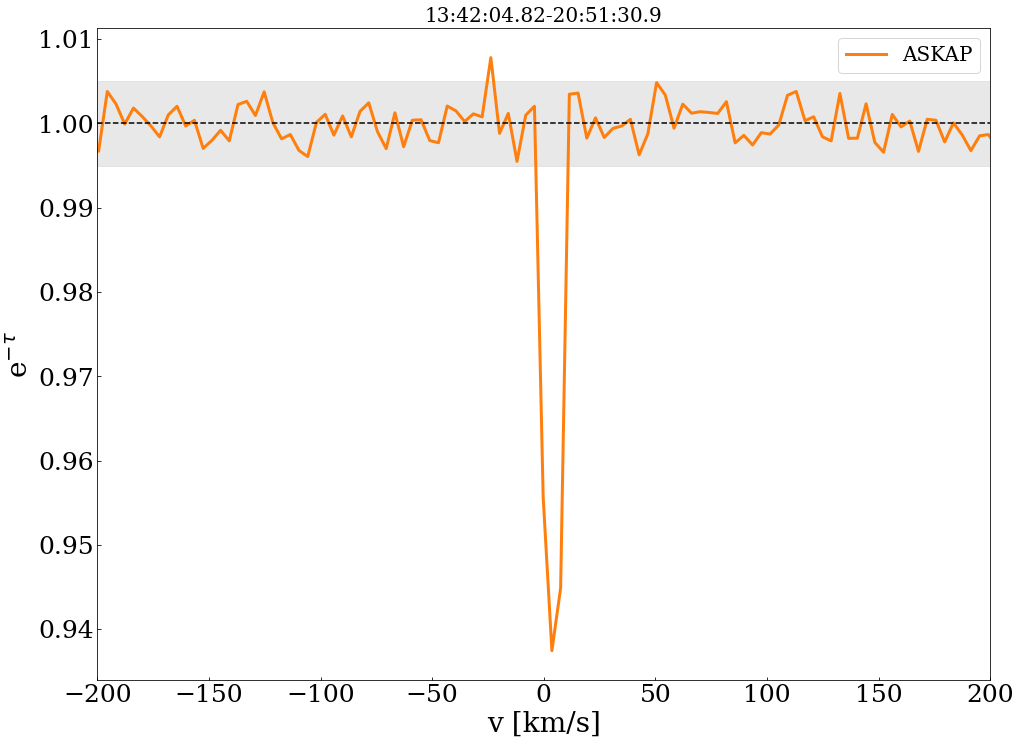

In [43]:
cube_askap = SpectralCube.read('/Users/denes/Research/high_lat_HI/ASKAP_data/data_cubes/NGC5044_MW.fits')  # Open the FITS file for reading
askap = fits.open('/Users/denes/Research/high_lat_HI/ASKAP_data/data_cubes/NGC5044_MW.fits')  # Open the FITS file for reading
d_askap = askap[0].data
h_askap = askap[0].header
w_askap = WCS(h_askap, askap)

coordinate = '{}{}'.format(h_askap['CRVAL1'], h_askap['CRVAL2'])
c = SkyCoord(coordinate, unit=(u.deg, u.deg))
print(c)
print(d_askap.shape)

MRO = EarthLocation.of_site('mro') 
barycorr = c.radial_velocity_correction(obstime=Time('2021-08-27'), location=MRO) 
restfreq = 1.420405752 * u.GHz  # rest frequency of HI
freq_to_vel = u.doppler_optical(restfreq) # using the radio convention
vel_askap = (cube_askap.spectral_axis).to(u.km / u.s, equivalencies=freq_to_vel) - barycorr/2



result = Vizier(column_filters={"S1.4":">150"}, row_limit=-1).query_constraints(catalog='VIII/65/nvss',RAJ2000='>{} & <{}'.format(c.ra.deg-3., c.ra.deg+3.), DEJ2000='>{} & <{}'.format(c.dec.deg-2, c.dec.deg+2))
print('number of sources:',len(result[0]))
#print(result[0]['RAJ2000'][0],result[0]['DEJ2000'][0])

detection = []

for i in range(len(result[0])):
    coord = '{} {}'.format(result[0]['RAJ2000'][i].replace(' ',':'),result[0]['DEJ2000'][i].replace(' ',':'))
    c2 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    pixels_askap = c2.to_pixel(w_askap)
    #print(coord )
    #print(pixels_askap)

    spectrum_askap = cube_askap[:, int(pixels_askap[1]), int(pixels_askap[0])]  # 10:09:10 -28:55:57
    tau_askap = np.log(spectrum_askap.value +1) * -1.
    rms = np.sqrt(np.mean(spectrum_askap.value**2))
    
    if abs(np.min(spectrum_askap.value)) > rms*4:
        detection.append(i)

        # plot
        fig = plt.figure(figsize=(16, 12))
        ax = fig.add_subplot(111)
        ax.set_title('{}{}'.format(result[0]['RAJ2000'][i].replace(' ',':'),result[0]['DEJ2000'][i].replace(' ',':')), fontsize=20)

        plt.plot(vel_askap, spectrum_askap.value+1, 'C1', linewidth=3, label='ASKAP')
        ax.axhspan(1-rms, 1+rms, alpha=0.5, color='lightgrey')
        #plt.title('102809-264418', fontsize=30)
        plt.ylabel(r'e$^{-\tau}$', fontsize=28)
        plt.xlabel("v [km/s]", fontsize=28)
        plt.xlim(-200,200)
        #plt.ylim(0.92,1.02)
        plt.axhline(1, color='k', linestyle='--')
        plt.legend(fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=25)
        fig.savefig('./spectra_plots/{}{}_ASKAP_spectra.png'.format(result[0]['RAJ2000'][i].replace(' ',''),result[0]['DEJ2000'][i].replace(' ','')))

print('4 sigma detections:', len(detection))    

In [16]:
# read in ASKAP catalogue

data_1 = pd.read_xml('/Users/denes/Research/high_lat_HI/ASKAP_data/continuum_cat/selavy-image.i.NGC5044_4A.SB25701.cont.taylor.0.restored.conv.islands.xml')

df = pd.DataFrame(data_1)


# concatenate catalogues


print(data_1.keys())

AttributeError: module 'pandas' has no attribute 'read_xml'

In [40]:
from astropy.io.votable import parse
from astropy.io.votable import parse_single_table
table = parse_single_table('/Users/denes/Research/high_lat_HI/ASKAP_data/continuum_cat/selavy-image.i.NGC5044_4A.SB25701.cont.taylor.0.restored.conv.islands.xml')



In [41]:
np.array(table.array['ra_hms_cont'])[0]

b'13:28:37.8'

In [47]:
# Importing the required libraries
import xml.etree.ElementTree as Xet
import pandas as pd
  
cols = ['ra_hms_cont', 'dec_hms_cont']
rows = []
file = '/Users/denes/Research/high_lat_HI/ASKAP_data/continuum_cat/selavy-image.i.NGC5044_4A.SB25701.cont.taylor.0.restored.conv.islands.xml'

# Parsing the XML file
xmlparse = Xet.parse(file)
root = xmlparse.getroot()
for i in root:
    name = i.find("ra_hms_cont").text
    phone = i.find("dec_hms_cont").text
  
    rows.append({'ra_hms_cont': name,
                 'dec_hms_cont': phone})
  
df = pd.DataFrame(rows, columns=cols)

# Writing dataframe to csv
df.to_csv('output.csv')

AttributeError: 'NoneType' object has no attribute 'text'